In [1]:
import os
from collections import Counter
from itertools import chain

import numpy as np
import pandas
from dotenv import load_dotenv
from matplotlib import pyplot
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image, ImageDraw
from sklearn.manifold import TSNE

In [2]:
load_dotenv()

data_dir = os.environ.get('DATA_DIR')
img_dir = os.environ.get('IMG_DIR')

# Load data

In [3]:
def load_followers(name):
    path = os.path.join(data_dir, name)
    return set(np.loadtxt(path, dtype=np.unicode))

In [4]:
names = os.listdir(data_dir)
followerss = [load_followers(name) for name in names]
icon_paths = [os.path.join(img_dir, name + '.jpg') for name in names]

# Stats

In [5]:
n_users = len(names)
n_users

73

In [6]:
sum_of_followers = sum([len(lst) for lst in followerss])
sum_of_followers

4300386

In [7]:
num_of_unique_followers = len(set().union(*followerss))
num_of_unique_followers

465462

In [8]:
num_of_unique_followers / sum_of_followers

0.10823726056219139

# Distribution of number of followings

In [9]:
counter = Counter(chain.from_iterable(followerss))
distribution = Counter(counter.values())

df = pandas.DataFrame(
    list(distribution.items()),
    columns=['number_of_followings', 'population']
).sort_values('number_of_followings')

df.style.hide_index()

number_of_followings,population
1,182385
2,60070
3,36276
4,23799
5,17270
6,13082
7,10389
8,8784
9,7243
10,6290


# Similarity

In [10]:
def jaccard(a, b):
    return len(a & b) / len(a | b)


def dice(a, b):
    return 2 * len(a & b) / (len(a) + len(b))


def simpson(a, b):
    return len(a & b) / min(len(a), len(b))


def similarity_matrix(sim):
    arr = np.zeros((n_users, n_users))
    
    for i in range(n_users):
        for j in range(n_users):
            arr[i, j] = sim(followerss[i], followerss[j])
    
    return arr

In [11]:
jaccard_mat = 1 - similarity_matrix(jaccard)
dice_mat = 1 - similarity_matrix(dice)
simpson_mat = 1 - similarity_matrix(simpson)

In [12]:
tsne = TSNE(
    n_components=2,
    metric='precomputed',
    perplexity=5,
    random_state=0,
    n_iter=10000,
    n_iter_without_progress=10000
)

In [13]:
jaccard_embedded = tsne.fit_transform(jaccard_mat)
dice_embedded = tsne.fit_transform(dice_mat)
simpson_embedded = tsne.fit_transform(simpson_mat)

# Plot the embedded vectors

In [14]:
def crop_circle(img):
    x, y = img.size
    mask = Image.new("1", img.size, 0)
    draw = ImageDraw.Draw(mask)
    result = img.copy()
    
    draw.ellipse((0, 0, x, y), fill=1)    
    result.putalpha(mask)

    return result


def plot_icons(embedded, fig_size=(10, 10), dpi=200, icon_size=15):
    xs, ys = zip(*embedded)
    
    fig = pyplot.figure(figsize=fig_size, dpi=dpi)
    ax = fig.add_subplot(111)
    ax.scatter(xs, ys)

    for x, y, path in zip(xs, ys, icon_paths):
        arr = np.asarray(crop_circle(Image.open(path)))
        zoom = icon_size / max(arr.shape)
        ab = AnnotationBbox(OffsetImage(arr, zoom), (x, y), frameon=False)
        ax.add_artist(ab)

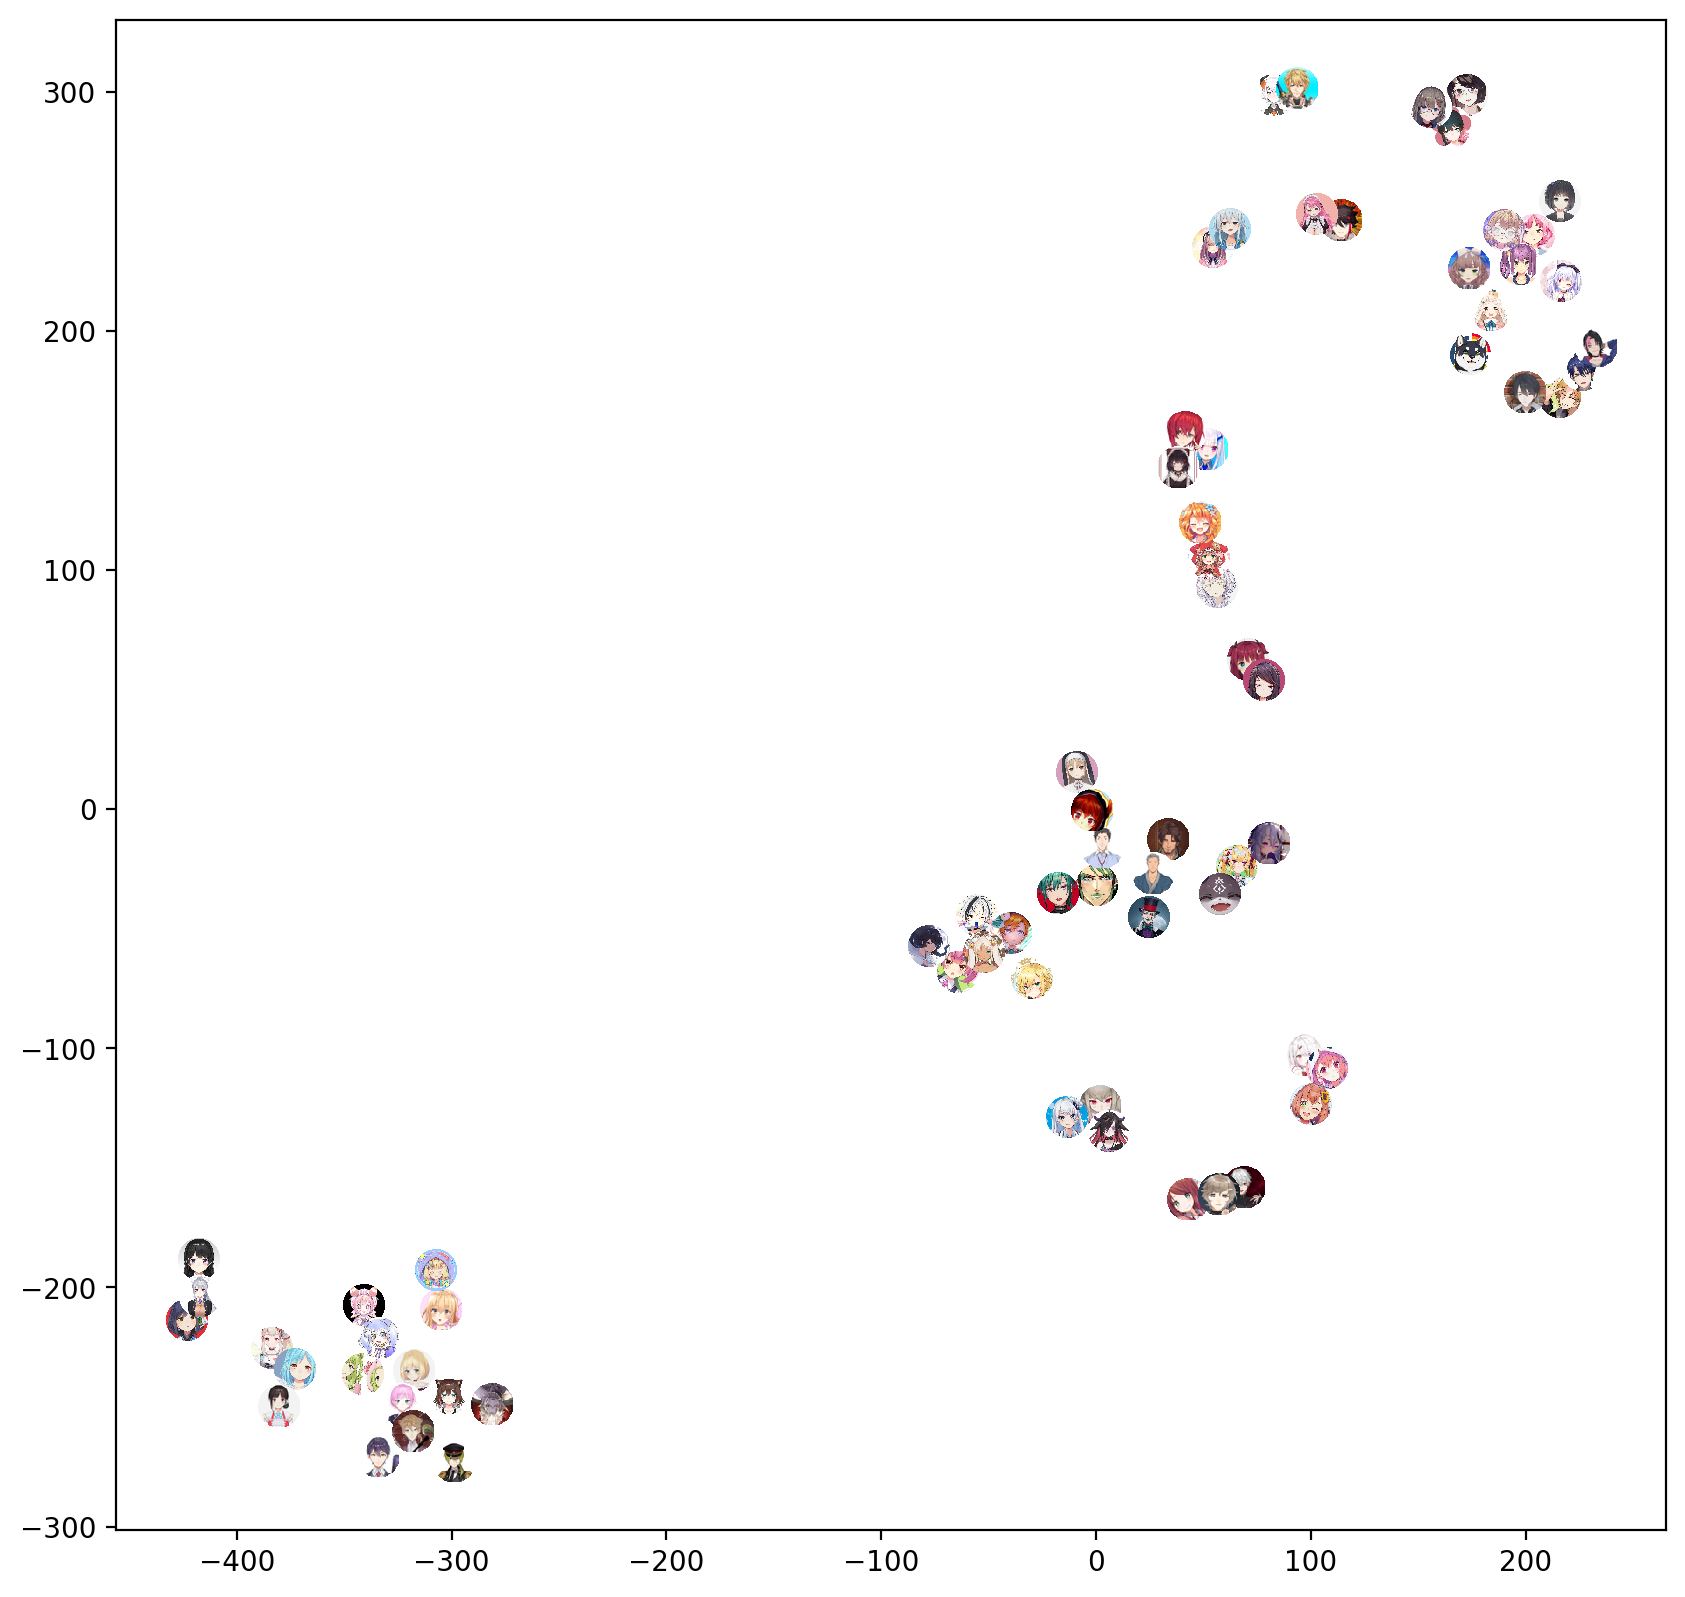

In [15]:
plot_icons(jaccard_embedded)

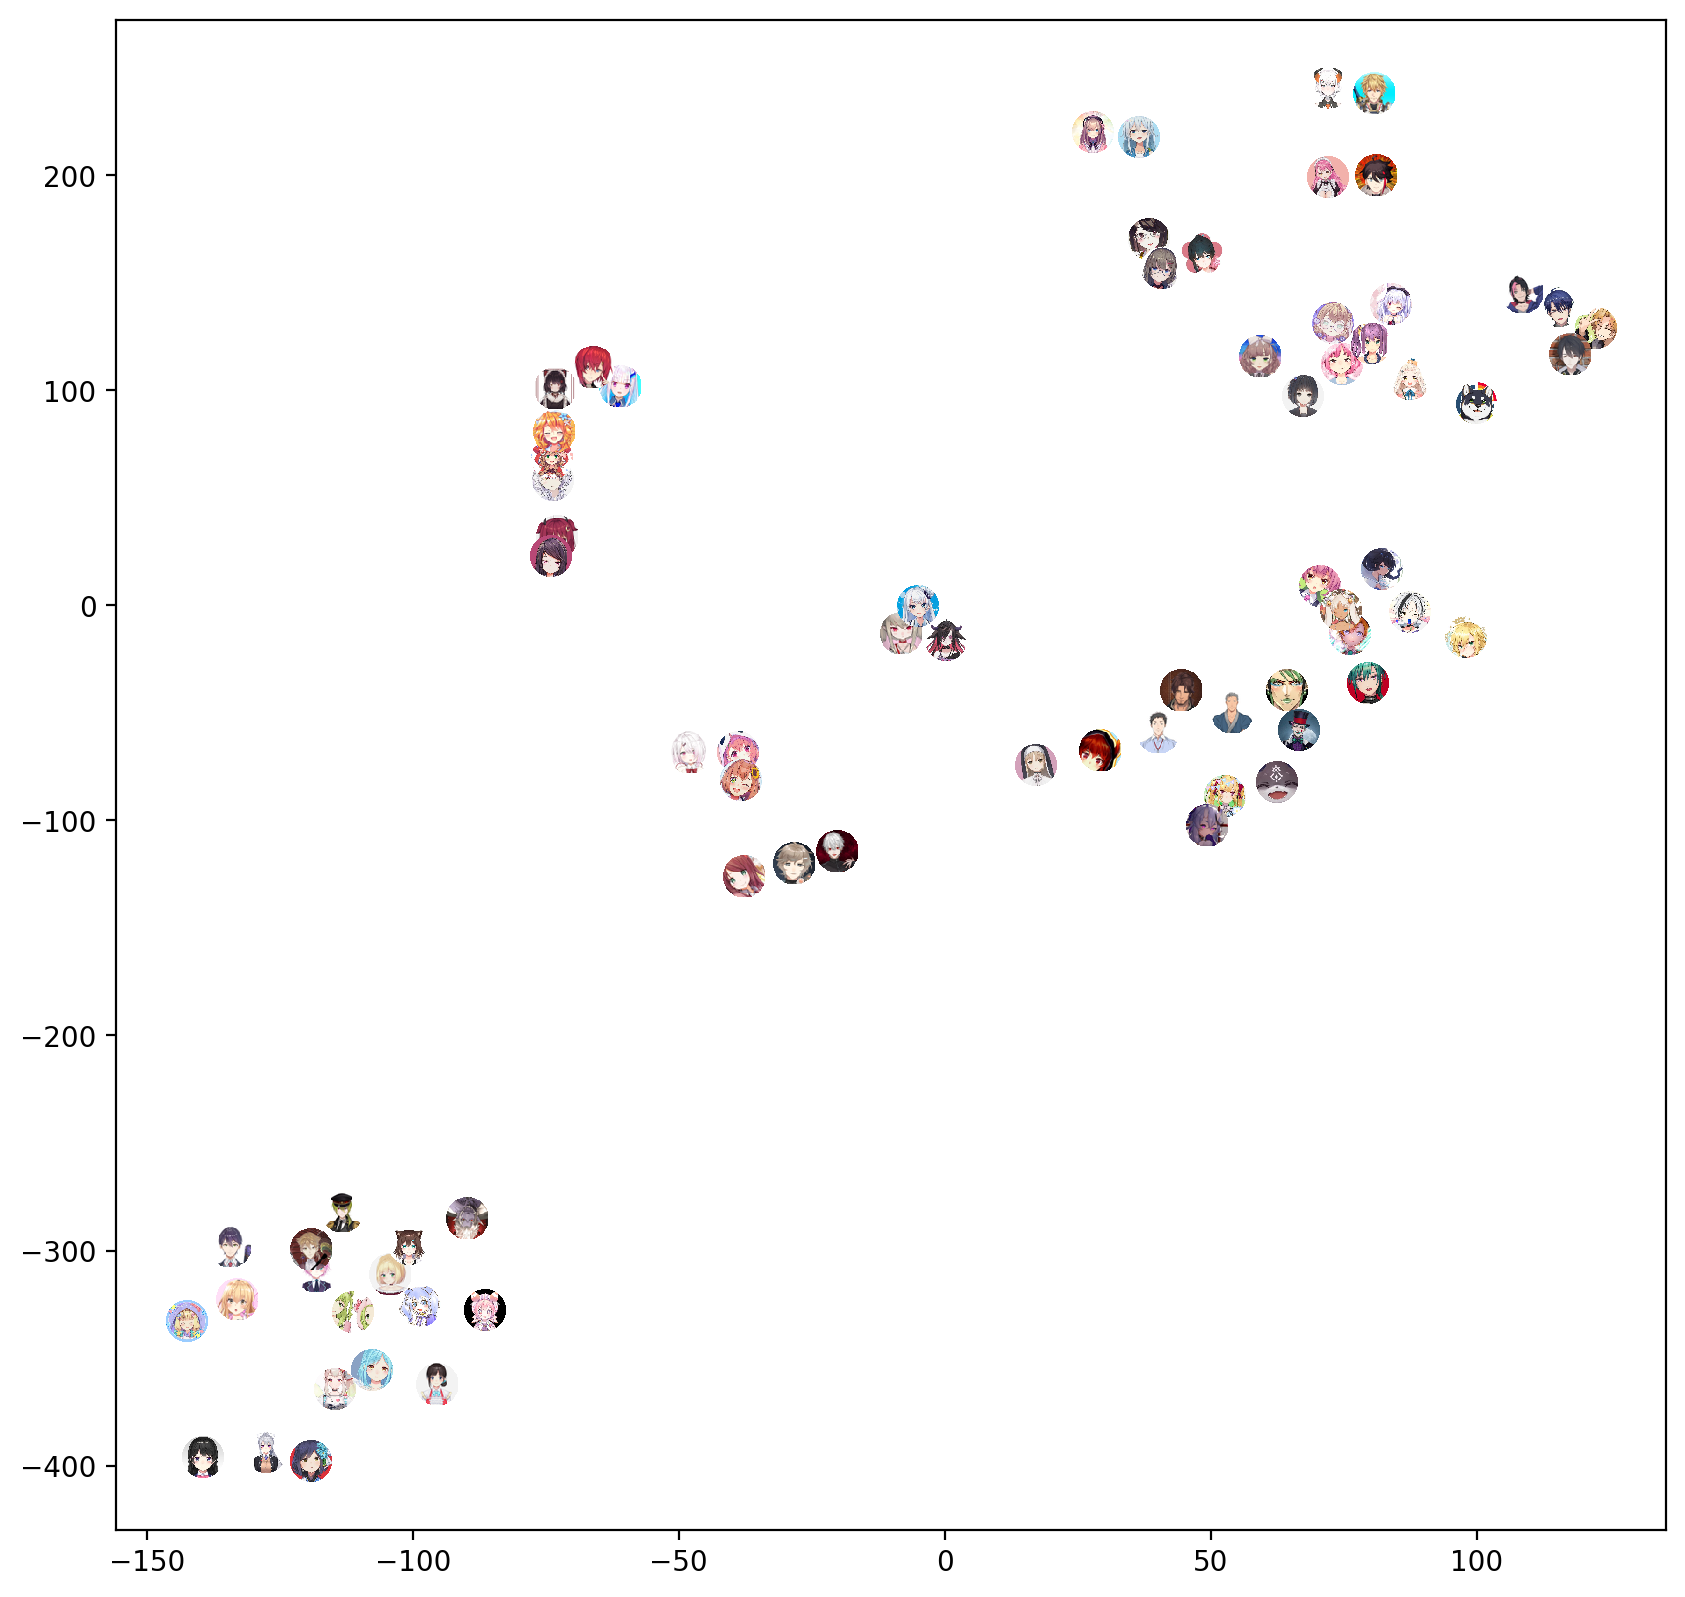

In [16]:
plot_icons(dice_embedded)

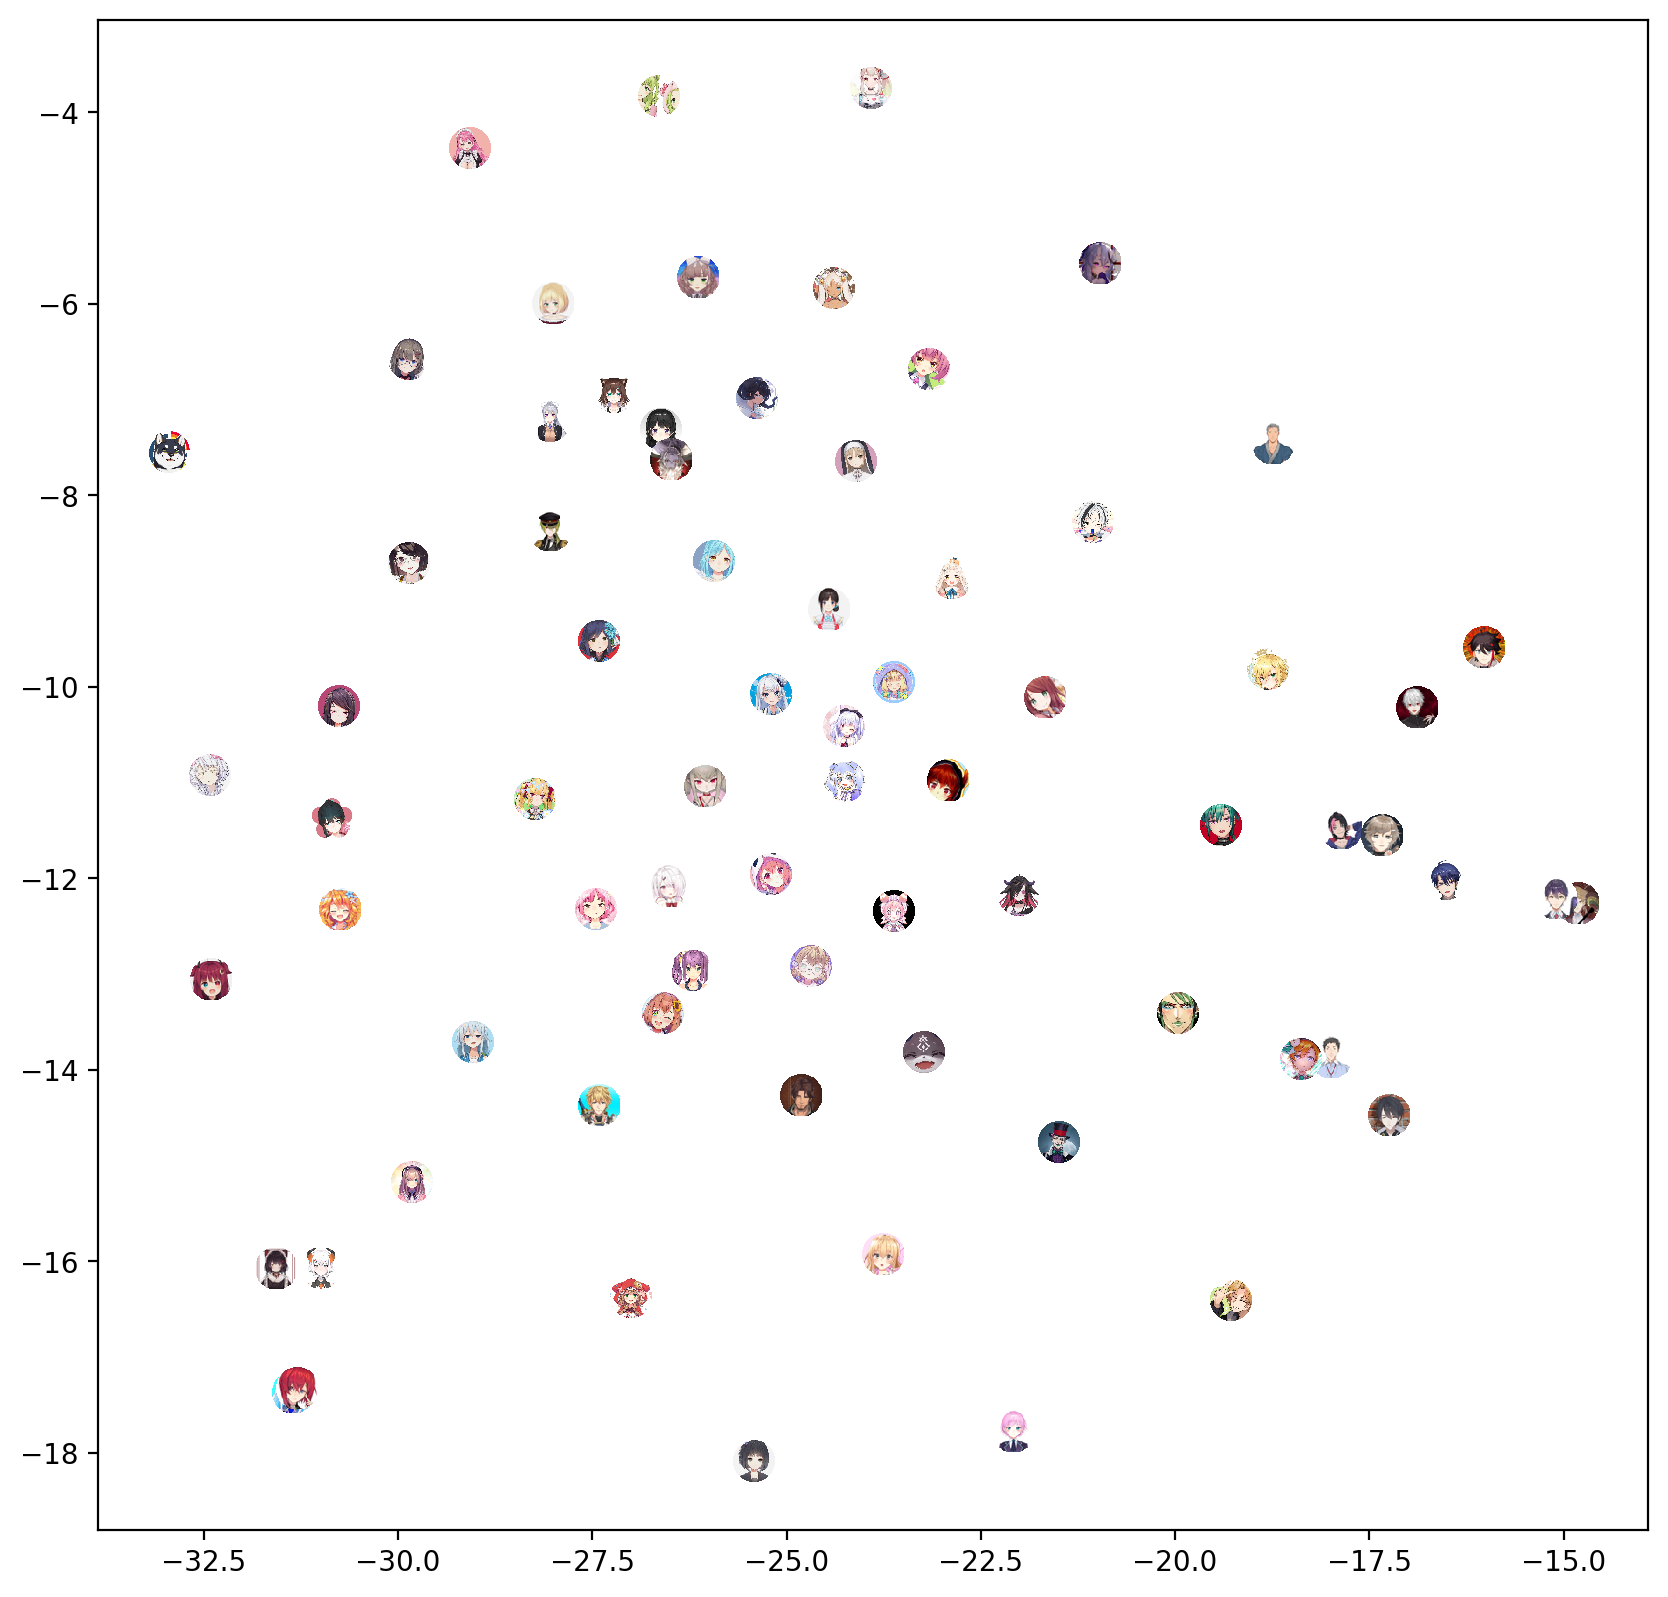

In [17]:
plot_icons(simpson_embedded)